# TTS Inference

This notebook can be used to generate audio samples using either NeMo's pretrained models or after training a NeMo TTS model. This script currently uses a two step inference procedure. First, a model is used to text into a mel spectrogram. Second, a model is turn mel spectrograms into audio.

Currently supported models are:
Mel Spectrogram Generators:
- Tacotron 2

Audio Generators
- Grifflin-Lim
- WaveGlow

In [ ]:
# Copyright 2020 NVIDIA. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.
!pip install wget
!pip install nemo_toolkit[tts]

!mkdir configs
# !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/candidate/examples/tts/conf/tacotron2.yaml
# !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/candidate/examples/tts/conf/waveglow.yaml
CONFIG_PATH = "conf/"

In [ ]:
from pathlib import Path

try: CONFIG_PATH
except NameError: CONFIG_PATH = Path("..") / "conf"
    
# supported_spec_gen = ["tacotron2"]
# supported_audio_gen = ["grifflin-lim", "waveglow"]
# supported_audio_gen_req_checkpoint = ["waveglow"]

# print("Choose one of the following spectrogram generators:")
# print([model for model in supported_spec_gen])
# spectrogram_generator = input()
# print("Choose one of the following audio generators:")
# print([model for model in supported_audio_gen])
# audio_generator = input()

# assert spectrogram_generator in supported_spec_gen
# assert audio_generator in supported_audio_gen

# Download pre-trained checkpoints

TODO: Enable downloading pretrained models

In [ ]:
# spectrogram_generator_checkpoint_path = input(f"Input the path to the {spectrogram_generator} checkpoint: ")
# # if audio_generator in supported_audio_gen_req_checkpoint:
# audio_generator_checkpoint_path = input(f"Input the path to the {audio_generator} checkpoint: ")

In [1]:
import copy

def _check_model_old_version(model):
    if "waveglow.WN.0.res_layers" in model or "waveglow.WN.0.cond_layers" in model:
        return True
    else:
        return False


def _update_model_res_skip(old_model, new_model):
    for idx in range(0, len(new_model.WN)):
        wavenet = new_model.WN[idx]
        n_channels = wavenet.n_channels
        n_layers = wavenet.n_layers
        wavenet.res_skip_layers = torch.nn.ModuleList()
        for i in range(0, n_layers):
            if i < n_layers - 1:
                res_skip_channels = 2*n_channels
            else:
                res_skip_channels = n_channels
            res_skip_layer = torch.nn.Conv1d(n_channels, res_skip_channels, 1)
            skip_layer = torch.nn.utils.remove_weight_norm(wavenet.skip_layers[i])
            if i < n_layers - 1:
                res_layer = torch.nn.utils.remove_weight_norm(wavenet.res_layers[i])
                res_skip_layer.weight = torch.nn.Parameter(torch.cat([res_layer.weight, skip_layer.weight]))
                res_skip_layer.bias = torch.nn.Parameter(torch.cat([res_layer.bias, skip_layer.bias]))
            else:
                res_skip_layer.weight = torch.nn.Parameter(skip_layer.weight)
                res_skip_layer.bias = torch.nn.Parameter(skip_layer.bias)
            res_skip_layer = torch.nn.utils.weight_norm(res_skip_layer, name='weight')
            wavenet.res_skip_layers.append(res_skip_layer)
        del wavenet.res_layers
        del wavenet.skip_layers

def _update_model_cond(old_model, new_model):
    for idx in range(0, len(new_model.WN)):
        wavenet = new_model.WN[idx]
        n_channels = wavenet.n_channels
        n_layers = wavenet.n_layers
        n_mel_channels = wavenet.cond_layers[0].weight.shape[1]
        cond_layer = torch.nn.Conv1d(n_mel_channels, 2*n_channels*n_layers, 1)
        cond_layer_weight = []
        cond_layer_bias = []
        for i in range(0, n_layers):
            _cond_layer = torch.nn.utils.remove_weight_norm(wavenet.cond_layers[i])
            cond_layer_weight.append(_cond_layer.weight)
            cond_layer_bias.append(_cond_layer.bias)
        cond_layer.weight = torch.nn.Parameter(torch.cat(cond_layer_weight))
        cond_layer.bias = torch.nn.Parameter(torch.cat(cond_layer_bias))
        cond_layer = torch.nn.utils.weight_norm(cond_layer, name='weight')
        wavenet.cond_layer = cond_layer
        del wavenet.cond_layers

def update_model(old_model):
#     if not _check_model_old_version(old_model):
#         return old_model
    new_model = copy.deepcopy(old_model)
    if "WN.0.res_layers" in old_model:
        print("update")
        _update_model_res_skip(old_model, new_model)
    if "WN.0.cond_layers" in old_model:
        print("update 2")
        _update_model_cond(old_model, new_model)
    return new_model

In [2]:
from nemo.collections.tts.models import Tacotron2Model, WaveGlowModel
from omegaconf import OmegaConf
import torch

def load_tacotron2_model(cfg):
    with open(cfg) as file:
        tacotron2_config = OmegaConf.load(file)
    del tacotron2_config.model["train_ds"]
    del tacotron2_config.model["validation_ds"]
    del tacotron2_config.model["optim"]
    return Tacotron2Model(cfg=tacotron2_config.model), tacotron2_config.labels

def load_waveglow_model(cfg):
    with open(cfg) as file:
        wave_config = OmegaConf.load(file)
    del wave_config.model["train_ds"]
    del wave_config.model["validation_ds"]
    del wave_config.model["optim"]
    return WaveGlowModel(cfg=wave_config["model"])

from ruamel.yaml import YAML
tacotron2, labels = load_tacotron2_model("/home/jasoli/nemo/NeMo/examples/tts/conf/tacotron2.yaml")
waveglow = load_waveglow_model("/home/jasoli/nemo/NeMo/examples/tts/conf/waveglow.yaml")

tacotron2.load_state_dict(torch.load("/home/jasoli/nemo/NeMo/examples/tts/experiments/1325283-Tacotron_O0_LJS_V1b/Tacotron 2/2020-07-24_21-39-14/checkpoints/Tacotron 2--last.ckpt")["state_dict"])
waveglow_checkpoint = torch.load("/home/jasoli/nemo/NeMo/examples/tts/experiments/1318094-Waveglow_O1_LJS_V1b/WaveGlow/2020-07-21_15-17-19/checkpoints/WaveGlow--last.ckpt")["state_dict"]
if "waveglow.WN.0.in_layers.0.bias" in waveglow_checkpoint:
    keys_to_del = []
    new_dict = {}
    for key, val in waveglow_checkpoint.items():
        if "WN" in key:
            new_dict[key.replace(".WN.", ".wavenet.")] = val
    for key in keys_to_del:
        del waveglow_checkpoint[key]
    for key, val in new_dict.items():
        waveglow_checkpoint[key] = new_dict[key]
# waveglow_checkpoint = update_model(waveglow_checkpoint)
waveglow.load_state_dict(waveglow_checkpoint, strict=False)

tacotron2 = tacotron2.cuda()
waveglow = waveglow.cuda()


/home/jasoli/ptl_venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
[NeMo W 2020-07-27 15:09:52 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-07-27 15:09:52 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-07-27 15:09:52 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is no

[NeMo I 2020-07-27 15:09:52 distilbert:33] DistilBert doesn’t use token_type_ids, and it will be ignored.


[NeMo W 2020-07-27 15:09:52 experimental:28] Module <class 'nemo.collections.nlp.modules.common.huggingface.distilbert.DistilBertEncoder'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-07-27 15:09:52 experimental:28] Module <class 'nemo.collections.nlp.modules.common.huggingface.roberta.RobertaEncoder'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-07-27 15:09:52 experimental:28] Module <class 'nemo.collections.nlp.modules.common.sequence_classifier.SequenceClassifier'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-07-27 15:09:52 experimental:28] Module <class 'nemo.collections.nlp.modules.common.token_classifier.TokenClassifier'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-07-27 15:09:52 experimental:28] Module <class 'nemo.collections.nlp.modules.com

[NeMo I 2020-07-27 15:09:52 features:154] PADDING: 16


/home/jasoli/ptl_venv/lib/python3.6/site-packages/hydra/_internal/utils.py:580: UserWarning: Config key 'model.preprocessor.cls' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
Use 'target' instead of 'cls'.
  category=UserWarning,


[NeMo I 2020-07-27 15:09:52 features:162] STFT using conv
[NeMo I 2020-07-27 15:09:53 modelPT:185] No optimizer config provided, therefore no optimizer was created
[NeMo I 2020-07-27 15:09:53 features:154] PADDING: 16


/home/jasoli/ptl_venv/lib/python3.6/site-packages/hydra/_internal/utils.py:580: UserWarning: Config key 'model.encoder.cls' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
Use 'target' instead of 'cls'.
  category=UserWarning,
/home/jasoli/ptl_venv/lib/python3.6/site-packages/hydra/_internal/utils.py:580: UserWarning: Config key 'model.decoder.cls' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
Use 'target' instead of 'cls'.
  category=UserWarning,
/home/jasoli/ptl_venv/lib/python3.6/site-packages/hydra/_internal/utils.py:580: UserWarning: Config key 'model.postnet.cls' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
Use 'target' instead of 'cls'.
  category=UserWarning,


[NeMo I 2020-07-27 15:09:53 features:162] STFT using conv


/home/jasoli/ptl_venv/lib/python3.6/site-packages/hydra/_internal/utils.py:580: UserWarning: Config key 'model.waveglow.cls' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
Use 'target' instead of 'cls'.
  category=UserWarning,


[NeMo I 2020-07-27 15:09:55 modelPT:185] No optimizer config provided, therefore no optimizer was created


In [8]:
def t2_infer(model, input_string, labels):
    model.eval()
    labels_dict = { char:i for i, char in enumerate(labels)}
    tokens = [len(labels)]
    for char in input_string:
        tokens.append(labels_dict[char])
    tokens.append(len(labels)+1)
    token_len = torch.tensor(len(tokens)).unsqueeze(0).cuda()
    tokens = torch.tensor(tokens).unsqueeze(0).cuda()
    print(tokens.shape)
    token_embedding = model.text_embedding(tokens).transpose(1, 2)
    encoder_embedding = model.encoder(token_embedding=token_embedding, token_len=token_len)
    spec_dec, gate, alignments, _ = model.decoder(memory=encoder_embedding, memory_lengths=token_len)
    spec_postnet = model.postnet(mel_spec=spec_dec)
    
    return spec_postnet

def wg_infer(model, spec):
    model.eval()
    model.mode = 2
    model.waveglow.mode = 2
    model.waveglow(spect=spec, run_inverse=True, audio=None)
    return model.waveglow(spect=spec, run_inverse=True, audio=None)

spec = t2_infer(tacotron2, "this is a test of tacotron two and waveglow", labels)
audio = wg_infer(waveglow, spec)

print(spec)
print(audio)

torch.Size([1, 45])
tensor([[[ -6.9645,  -6.4156,  -6.5853,  ...,  -8.8591,  -8.8101,  -8.4670],
         [ -6.4220,  -5.5664,  -5.5490,  ...,  -7.5568,  -7.5305,  -7.3270],
         [ -5.6744,  -4.7796,  -4.6122,  ...,  -6.7965,  -6.7989,  -6.5737],
         ...,
         [ -9.0351,  -7.9048,  -6.9571,  ...,  -9.6327,  -9.6858,  -9.5850],
         [ -9.0795,  -7.8815,  -6.8831,  ...,  -9.8105,  -9.8810,  -9.7476],
         [ -9.7113,  -8.3659,  -7.3442,  ..., -10.5890, -10.6838, -10.5541]]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[-1.9138e-04, -6.5264e-05,  2.1595e-04,  ...,  7.0408e-04,
          6.8000e-04,  8.2079e-04]], device='cuda:0', grad_fn=<ViewBackward>)


# Create the Tacotron 2 + WaveGlow Models

In [9]:
# waveglow_checkpoint = torch.load("/home/jasoli/nemo/NeMo/examples/tts/experiments/1318094-Waveglow_O1_LJS_V1b/WaveGlow/2020-07-21_15-17-19/checkpoints/WaveGlow--last.ckpt")

## Lets hear the generated audio !

In [10]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow

ipd.Audio(audio.detach().cpu().numpy(), rate=22050)

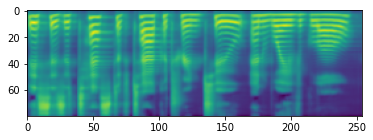

In [11]:
%matplotlib inline
imshow(spec.detach().cpu().numpy()[0])
# img = Image.fromarray(spec.detach().cpu().numpy()[0])
# ipd.Image(img)

In [ ]:
print(audio)